In [70]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt

### STEP 0 Create Dateframe

In [3]:
df = pd.read_feather("/Users/irislee/Uchicago Class Materials/3. 2Q/Python for Analytics/Assignment/RC_2012_year_cohort.feather")

### STEP 1 Find the top 30 subreddits

In [87]:
subreddit_comment_counts = df['subreddit'].value_counts()
top30_subreddits = subreddit_comment_counts.head(30).index.tolist() # Change to 30 later
top30_subreddits = top30_subreddits[28:30]

In [88]:
top30_subreddits

['Games', 'guns']

In [92]:
## TMP - Delete Later
df_test = df[(df['subreddit'] == 'guns') | (df['subreddit'] == 'Games')]
file_name = "guns_games.csv"
df_test.to_csv(file_name, index = False, encoding='utf-8')
df_tmp = pd.read_csv('guns_games.csv')
df_tmp.head(3)

,created_utc,author,subreddit
0,1325376008,Pomberella2,guns
1,1325376009,CountNefarious,guns
2,1325376024,mt3chn1k,guns


### STEPS 2 ~ 8

In [94]:
df_tmp['created_date'] = pd.to_datetime(df_tmp['created_utc'], unit='s').dt.date

In [95]:
start_time = time.time()
subreddit_dfs = {}

for subreddit in top30_subreddits:
    subreddit_df = df_tmp[df_tmp['subreddit'] == subreddit][['author', 'created_date']].drop_duplicates()

    # create first_comment_df
    first_comment_df = subreddit_df.groupby('author')['created_date'].min().reset_index(name='first_comment_date')
    
    # merge subreddit_df with first_comment_df based on author
    combined_df = pd.merge(subreddit_df[['author', 'created_date']], first_comment_df, on='author')
    
    # calculate number of days since first comment
    combined_df['days_since_first_comment'] = (combined_df['created_date'] - combined_df['first_comment_date']).dt.days

    # group by author and days since first comment and count the number of rows
    daily_activity_df = combined_df.groupby(['author', 'days_since_first_comment']).size().reset_index(name='activity_count')

    # pivot the dataframe for the subreddit so that names of authors are on one axis and the days on which they commented are on the second axis
    pivot_df = daily_activity_df.pivot(index='days_since_first_comment', columns='author', values='activity_count').fillna(0)
    
    # sum the number of commenters for each day
    commenters_per_day = pivot_df.sum(axis=1)
    
    # calculate the % of authors who returned after their first comment
    authors_day_0 = len(daily_activity_df[daily_activity_df['days_since_first_comment'] == 0]['author'].unique())
    authors_retained = daily_activity_df[daily_activity_df['days_since_first_comment'] > 0]['author'].unique()
    
    retention_pct = []
    for i in range(1, len(commenters_per_day)):
        authors_returned = len(set(daily_activity_df[(daily_activity_df['days_since_first_comment'] == i) & (daily_activity_df['author'].isin(authors_retained))]['author']))
        retention_pct.append(authors_returned/authors_day_0)
        
    # store the results in the dictionary
    subreddit_dfs[f'{subreddit}_retention_pct'] = retention_pct
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 31.248234033584595 seconds


In [109]:
# combined_df[combined_df['author'] == 'CountNefarious'].head(2)
# daily_activity_df[daily_activity_df['author'] == 'CountNefarious'].head(2)
# pivot_df['CountNefarious'].tolist()
# subreddit_dfs['guns_retention_pct']

### STEP 9

Games
guns


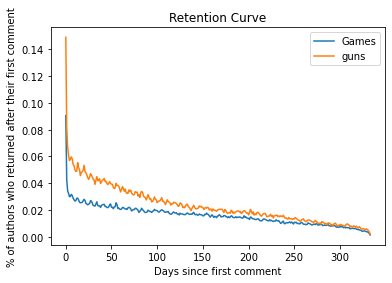

In [96]:
fig, ax = plt.subplots()

for subreddit in top30_subreddits:
    print(subreddit)
    retention_pct = subreddit_dfs[f'{subreddit}_retention_pct']
    ax.plot(retention_pct, label=subreddit)

ax.set_xlabel('Days since first comment')
ax.set_ylabel('% of authors who returned after their first comment')
ax.set_title('Retention Curve')
ax.legend()

plt.show()